In [0]:
!pip install --upgrade tensorflow tensorflow-quantum matplotlib numpy sympy cirq pydot graphviz gast==0.2.2

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc1)
Requirement already up-to-date: tensorflow-quantum in /usr/local/lib/python3.6/dist-packages (0.2.0)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.2.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.18.2)
Requirement already up-to-date: sympy in /usr/local/lib/python3.6/dist-packages (1.5.1)
Requirement already up-to-date: cirq in /usr/local/lib/python3.6/dist-packages (0.7.0)
Requirement already up-to-date: pydot in /usr/local/lib/python3.6/dist-packages (1.4.1)
Requirement already up-to-date: graphviz in /usr/local/lib/python3.6/dist-packages (0.13.2)


In [0]:
!pip install --upgrade tensorflow pydot graphviz

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc1)
Requirement already up-to-date: pydot in /usr/local/lib/python3.6/dist-packages (1.4.1)
Requirement already up-to-date: graphviz in /usr/local/lib/python3.6/dist-packages (0.13.2)


In [0]:
!pip install tensorflow==1.15.0 gast==0.2.2

     |████████████████████████████████| 412.3MB 38kB/s 
Processing /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd/gast-0.2.2-cp36-none-any.whl
     |████████████████████████████████| 512kB 43.6MB/s 
     |████████████████████████████████| 3.8MB 48.1MB/s 
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorboard 2.1.1
    Uninstalling tensorboard-2.1.1:
      Successfully uninstalled tensorboard-2.1.1
  Found existing installation: tensorflow 2.2.0rc1
    Uninstalling tensorflow-2.2.0rc1:
      Successfully uninstalled tensorflow-2.2.0rc1


In [0]:
!pip install tensorflow-quantum gast==0.2.2

     |████████████████████████████████| 5.3MB 2.6MB/s 
     |████████████████████████████████| 1.2MB 40.5MB/s 
ERROR: tensorflow 2.1.0 has requirement tensorboard<2.2.0,>=2.1.0, but you'll have tensorboard 1.15.0 which is incompatible.
  Found existing installation: sympy 1.5.1
    Uninstalling sympy-1.5.1:
      Successfully uninstalled sympy-1.5.1
  Found existing installation: protobuf 3.10.0
    Uninstalling protobuf-3.10.0:
      Successfully uninstalled protobuf-3.10.0


In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq

import numpy as np
import sympy
import cirq
import seaborn as sns
import pandas as pd

%matplotlib inline
from matplotlib import style
style.use('bmh')
style.use('dark_background')

import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import pydot
import graphviz

%tensorflow_version 1.15
print(tf.__version__)

NotFoundError: ignored

## Loading data

In [0]:
data = np.asanyarray(pd.read_csv('./LabelledTheta.csv', delimiter=',', header=None))

NUM_CHANNELS = 14
NUM_THETA_VALUES_PER_CHANNEL = 36
AVG_COUNT = 2
NEW_NUM_THETA_VALUES_PER_CHANNEL = NUM_THETA_VALUES_PER_CHANNEL // AVG_COUNT -2
data

array([['Ankur_sir_6', 2.661255444814941, 15.135894568013981, ...,
        -0.08990728367798795, 0.5375088857254013, 'Like'],
       ['Sandeep_32', -4.419225848654918, -24.76187675161037, ...,
        -4.8016568491540434, 4.845698165412274, 'Disike'],
       ['mahendra_28', -1.5454615508228926, 0.4458772299785068, ...,
        0.3909845728846051, 0.3820759724008127, 'Like'],
       ...,
       ['mahendra_5', -12.76711513386849, -101.29815015753748, ...,
        -1.77307011766662, -6.1868765157224885, 'Like'],
       ['taufiq_10', -1.75569285697388, -6.889485709512044, ...,
        -2.2842198988711147, -8.576907597818206, 'Disike'],
       ['Vijay_32', 2.191135723676666, 10.285410138660891, ...,
        -2.9141951374834605, -3.2100352800372605, 'Disike']], dtype=object)

In [0]:
def normalize(X_data):
    for i in range(len(X_data)):
        mu = X_data[i].mean()
        sigma = X_data[i].std()
        
        X_data[i] = (X_data[i] - mu) / sigma
        
        for j in range(len(X_data[i])):
            if X_data[i][j] > 2:
                X_data[i][j] = 2
            elif X_data[i][j] < -2:
                X_data[i][j] = -2
                
        X_data[i] = ((X_data[i] / 5) + 0.5)
            
    return X_data

In [0]:
def get_angles(X_data):
    for i in range(len(X_data)):
        X_data[i] = np.array([2 * np.arcsin(np.sqrt(x)) for x in X_data[i]])
            
    return X_data

In [0]:
def reduce_data_size(X_data):
  X_data_reduced = []
  for i in range(len(X_data)):
    X_i = []
    for j in range(NUM_CHANNELS):
      for k in range(2, NUM_THETA_VALUES_PER_CHANNEL-2, AVG_COUNT):
        idx = j * NUM_THETA_VALUES_PER_CHANNEL + k
        X_i.append((X_data[i][idx] + X_data[i][idx+1])/2)
    
    X_data_reduced.append(np.array(X_i))

  return X_data_reduced

In [0]:
X = []
Y = []
for i in range(len(data)):
    X.append(data[i][1:-1])
    Y.append(data[i][-1])
    
X_norm = normalize(X)
X_ang_36 = get_angles(X_norm)

In [0]:
print(type(X_ang_36), type(X_ang_36[0]))

<class 'list'> <class 'numpy.ndarray'>


In [0]:
X_ang = reduce_data_size(X_ang_36)

In [0]:
print(len(X_ang), len(X_ang[0]))

1045 224


In [0]:
train_idxs = int(len(X_ang)*0.7)+1
test_idxs = int(train_idxs + len(X_ang)*0.2)

X_train = X_ang[:train_idxs]
Y_train = Y[:train_idxs]

X_test = X_ang[train_idxs:test_idxs]
Y_test = Y[train_idxs:test_idxs]

X_val = X_ang[test_idxs:]
Y_val = Y[test_idxs:]

In [0]:
Y_train_bin = np.array([1 if y == 'Like' else -1 for y in Y_train])
Y_test_bin = np.array([1 if y == 'Like' else -1 for y in Y_test])
Y_val_bin = np.array([1 if y == 'Like' else -1 for y in Y_val])

## Creating a quantum circuit

In [0]:
def convert_to_circuit(one_channel_X_data):
    '''Encode values in the quantum circuit by applying rotation gates.'''
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i in range(len(one_channel_X_data)):
        circuit.append(cirq.rx(one_channel_X_data[i]).on(qubits[i]))
    return circuit

In [0]:
def create_circuit_list(X_data):
  X_circ = []
  for i in range(NUM_CHANNELS):
    X_i = []
    start = i * NEW_NUM_THETA_VALUES_PER_CHANNEL
    end = start + NEW_NUM_THETA_VALUES_PER_CHANNEL
    for j in range(len(X_data)):
      X_i.append(convert_to_circuit(X_data[j][start:end]))
    
    X_circ.append(tfq.convert_to_tensor(X_i))

  return X_circ

In [0]:
X_train_circ = create_circuit_list(X_train)
X_test_circ = create_circuit_list(X_test)
X_val_circ = create_circuit_list(X_val)

In [0]:
print(len(X_train_circ), X_train_circ[0].shape)
print(len(X_test_circ), X_test_circ[0].shape)
print(len(X_val_circ), X_val_circ[0].shape)

14 (732,)
14 (209,)
14 (104,)


#### The cluster state circuit

In [0]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

#### QCNN Layers

In [0]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[7]]
    circuit += [cirq.YY(*bits)**symbols[8]]
    circuit += [cirq.XX(*bits)**symbols[9]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

#### Quantum Convolution

In [0]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

#### Quantum Pooling

In [0]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

### Defining the cluster state bits

In [0]:
cluster_state_bits = cirq.GridQubit.rect(4, 4)
readouts = [cirq.Z(bit) for bit in cluster_state_bits[12:]]

### Model definition

In [0]:
def multi_readout_model_circuit(qubits):
    """Make a model circuit with less quantum pool and conv operations."""
    split_idx = len(qubits)//2
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:split_idx], qubits[split_idx:], symbols[15:21])
    return model_circuit

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full 

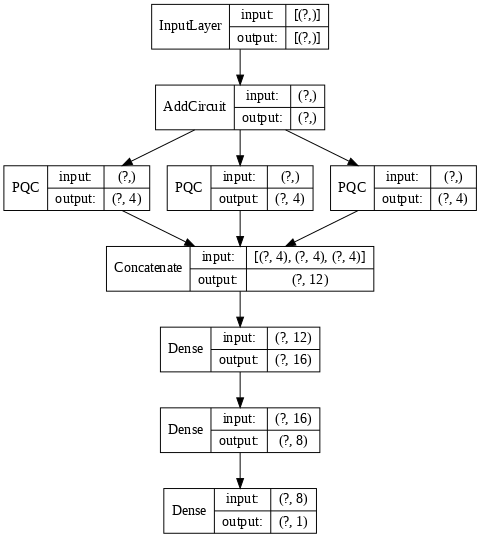

In [0]:
# Input layer
eeg_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

# Cluster state layer
cluster_state_layer = tfq.layers.AddCircuit()(eeg_input, prepend=cluster_state_circuit(cluster_state_bits))

# Quantum layers
quantum_layers = []

for i in range(3):
  quantum_layers.append(tfq.layers.PQC(multi_readout_model_circuit(cluster_state_bits), readouts)(cluster_state_layer))

# Contenate layer
concat_out = tf.keras.layers.concatenate(quantum_layers)

# Classical dense layers
dense_1 = tf.keras.layers.Dense(16)(concat_out)
dense_2 = tf.keras.layers.Dense(8)(dense_1)
dense_3 = tf.keras.layers.Dense(1)(dense_2)

# The ML model
hybrid_qcnn_model = tf.keras.Model(inputs=[eeg_input], outputs=[dense_3])

# Print the model
tf.keras.utils.plot_model(hybrid_qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

### Custom accuracy metric

In [0]:
# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))

In [0]:
hybrid_qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                          loss=tf.losses.mse,
                          metrics=[custom_accuracy])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 3, expecting 4


OperatorNotAllowedInGraphError: ignored

In [0]:
hybrid_qcnn_history = hybrid_qcnn_model.fit(x=X_train_circ[0],
                                            y=Y_train_bin,
                                            batch_size=1,
                                            epochs=1,
                                            verbose=1,
                                            validation_data=(X_test_circ[0], Y_test_bin))

Train on 732 samples, validate on 209 samples
